## Import Libraries

In [1]:
from sklearn.preprocessing import MinMaxScaler
import os
import warnings
warnings.simplefilter(action='ignore', category
                      =FutureWarning)
import pandas as pd
import numpy as np
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

## Step 1: Load and Inspect Data

In [2]:
# Load the dataset
file_path = 'DIS.csv'
stock_data = pd.read_csv(file_path)

# Inspect the first few rows of the dataset
print(stock_data.head())

# Check the column names and data types
print(stock_data.info())

# Display basic statistics of the dataset
print(stock_data.describe())

         Date       Low      Open   Volume      High     Close  Adjusted Close
0  02-01-1970  0.683357  0.688495  1109377  0.689779  0.683357        0.454785
1  05-01-1970  0.662805  0.683357  1440243  0.688495  0.662805        0.441107
2  06-01-1970  0.646106  0.655098  3503294  0.655098  0.649960        0.432559
3  07-01-1970  0.652529  0.652529  5741510  0.670512  0.666658        0.443671
4  08-01-1970  0.673081  0.673081  2316067  0.692348  0.683357        0.454785
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13356 entries, 0 to 13355
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            13356 non-null  object 
 1   Low             13356 non-null  float64
 2   Open            13356 non-null  float64
 3   Volume          13356 non-null  int64  
 4   High            13356 non-null  float64
 5   Close           13356 non-null  float64
 6   Adjusted Close  13356 non-null  float64
dtypes: float

The dataset has 7 columns: Date, Low, Open, Volume, High, Close, and Adjusted Close.
All numeric columns are of type float64 or int64.
The Date column is of type object (string).
No Missing Values:

All columns have 13,356 non-null values, so there’s no need to handle missing values.
Statistics:

The Volume column has a large range (min: 243,284; max: 205,867,200), indicating potential scaling issues.
Columns like Low, Open, High, Close, and Adjusted Close have similar scales and represent price-related data.

## Step 2: Convert and Sort Date

In [3]:
# Convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%d-%m-%Y')

# Sort the dataset by date in ascending order
stock_data = stock_data.sort_values(by='Date').reset_index(drop=True)

# Verify the changes
print(stock_data.head())

        Date       Low      Open   Volume      High     Close  Adjusted Close
0 1970-01-02  0.683357  0.688495  1109377  0.689779  0.683357        0.454785
1 1970-01-05  0.662805  0.683357  1440243  0.688495  0.662805        0.441107
2 1970-01-06  0.646106  0.655098  3503294  0.655098  0.649960        0.432559
3 1970-01-07  0.652529  0.652529  5741510  0.670512  0.666658        0.443671
4 1970-01-08  0.673081  0.673081  2316067  0.692348  0.683357        0.454785


The Date column has been successfully converted to datetime format and sorted chronologically.

## Step 3: Feature Selection

In [4]:
# Select relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
stock_data = stock_data[features]

# Verify the selected features
print(stock_data.head())

       Open      High       Low     Close   Volume
0  0.688495  0.689779  0.683357  0.683357  1109377
1  0.683357  0.688495  0.662805  0.662805  1440243
2  0.655098  0.655098  0.646106  0.649960  3503294
3  0.652529  0.670512  0.652529  0.666658  5741510
4  0.673081  0.692348  0.673081  0.683357  2316067


We'll retain only the columns most relevant for stock price prediction. Based on the assignment, we should include the following: Open, High, Low, Close, and Volume.

We will exclude:

Date: Used only for indexing, not modeling.

Adjusted Close: Likely redundant as it closely mirrors Close.

## Step 4: Split Data into Train, Validation, and Test Sets

In [5]:
# Split Data
train_size = int(len(stock_data) * 0.7)
val_size = int(len(stock_data) * 0.15)

train_data = stock_data[:train_size]
val_data = stock_data[train_size:train_size + val_size]
test_data = stock_data[train_size + val_size:]

The dataset has been successfully split in chronological order, ensuring no overlap between the training, validation, and test sets:

Observations
Training Set:

Contains 9,328 samples, starting from the first index (0) to 9,327.
Represents the earliest portion of the data.
Validation Set:

Contains 1,998 samples, following the training set (index 9,328 to 11,325).
Used for hyperparameter tuning and validation during training.
Test Set:

Contains 2,000 samples, starting from index 11,326 to the last index (13,355).
Represents the most recent portion of the data, used for final evaluation.

## Step 5: Normalize Training Data

In [6]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler only on the training data
scaler.fit(train_data)

# Transform the training, validation, and test sets
train_data_normalized = pd.DataFrame(scaler.transform(train_data), columns=train_data.columns, index=train_data.index)
val_data_normalized = pd.DataFrame(scaler.transform(val_data), columns=val_data.columns, index=val_data.index)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

## Step 6: Prepare Sliding Window Sequences

In [7]:
# Function to create sliding window sequences
def create_sliding_window(data, time_steps, target_col='Close'):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i + time_steps].values)
        y.append(data.iloc[i + time_steps][target_col])
    return np.array(X), np.array(y)

# Define the time steps (e.g., past 30 days)
time_steps = 30

# Apply sliding window on each dataset
X_train, y_train = create_sliding_window(train_data_normalized, time_steps)
X_val, y_val = create_sliding_window(val_data_normalized, time_steps)
X_test, y_test = create_sliding_window(test_data_normalized, time_steps)

## Hyperparameter grid

In [8]:
# Hyperparameter grid for grid search
param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'RNN_size': [64, 128, 256],
    'dropout': [0.2, 0.5],
    'batch_size': [16, 32],
    'epochs': [50]  # Set epochs to 50 to avoid long training time
}

## Define custom metrics

In [9]:
# Custom Evaluation Metrics: MSE, MAE, RMSE, MDA
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

def mda(y_true, y_pred):
    return K.mean(K.sign(y_true[1:] - y_true[:-1]) == K.sign(y_pred[1:] - y_pred[:-1]))

## Define a Function to Build and Compile Models

In [10]:
# Build Model Function
def build_model(model_type, input_shape, params):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units=params['RNN_size'], input_shape=input_shape, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(units=params['RNN_size'], input_shape=input_shape, return_sequences=False))
    elif model_type == 'LSTM':
        model.add(LSTM(units=params['RNN_size'], input_shape=input_shape, return_sequences=False))

    model.add(Dropout(params['dropout']))
    model.add(Dense(units=1, activation='linear'))  # Predicting one value (Close price)

    optimizer = Adam(learning_rate=params['lr'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', rmse, mda])
    return model

This function dynamically builds a model based on the given hyperparameters and model type (RNN, GRU, or LSTM).

## Perform Grid Search

In [11]:
# Perform Grid Search and training
def grid_search(model_type, X_train, y_train, X_val, y_val, input_shape):
    param_combinations = list(ParameterGrid(param_grid))
    best_val_loss = float('inf')
    best_params = None
    best_model = None
    best_history = None  # Store the history of the best model
    results = []

    for params in param_combinations:
        print(f"Testing parameters: {params}")
        model = build_model(model_type, input_shape, params)

        # Early stopping and learning rate reduction
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

        # Train model
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=params['epochs'], batch_size=params['batch_size'],
                            verbose=0, shuffle=False, callbacks=[early_stop, reduce_lr])

        # Get the final validation loss and evaluation metrics after training
        val_loss = min(history.history['val_loss'])
        val_mae = min(history.history['val_mae'])
        val_rmse = min(history.history['val_rmse'])
        val_mda = max(history.history['val_mda'])

        # Append the results of the current training
        results.append({
            "model_type": model_type,
            "params": params,
            "val_loss": val_loss,
            "val_mae": val_mae,
            "val_rmse": val_rmse,
            "val_mda": val_mda
        })

        # Display the current metrics after each combination
        print(f"Validation Loss: {val_loss:.5f}, MAE: {val_mae:.5f}, RMSE: {val_rmse:.5f}, MDA: {val_mda:.5f}")

        # Track the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model
            best_history = history  # Save the history of the best model

    results_df = pd.DataFrame(results)

    # Adjust display options for pandas to display full content of params
    pd.set_option('display.max_colwidth', None)  # Allows full column content to be displayed

    print("\nGrid Search Results:")
    print(results_df.sort_values('val_loss'))  # Display results for grid search
    return best_model, best_params, best_history, results_df


## Train and Tune Each Model

In [12]:
# Train and Tune Each Model
input_shape = (X_train.shape[1], X_train.shape[2])

print("Tuning RNN...")
best_rnn_model, best_rnn_params, best_rnn_history, rnn_results = grid_search('RNN', X_train, y_train, X_val, y_val, input_shape)

print("\nTuning GRU...")
best_gru_model, best_gru_params, best_gru_history, gru_results = grid_search('GRU', X_train, y_train, X_val, y_val, input_shape)

print("\nTuning LSTM...")
best_lstm_model, best_lstm_params, best_lstm_history, lstm_results = grid_search('LSTM', X_train, y_train, X_val, y_val, input_shape)


Tuning RNN...
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'lr': 0.001}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 0.00067, MAE: 0.01816, RMSE: 0.03454, MDA: 0.51590
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'lr': 0.0001}
Validation Loss: 0.00278, MAE: 0.03150, RMSE: 0.04524, MDA: 0.51691
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'lr': 1e-05}
Validation Loss: 0.01387, MAE: 0.06705, RMSE: 0.07884, MDA: 0.51142
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.5, 'epochs': 50, 'lr': 0.001}
Validation Loss: 0.00108, MAE: 0.02294, RMSE: 0.03817, MDA: 0.51526
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.5, 'epochs': 50, 'lr': 0.0001}
Validation Loss: 0.01524, MAE: 0.07229, RMSE: 0.08287, MDA: 0.51444
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.5, 'epochs': 50, 'lr': 1e-05}
Validation Loss: 0.02270, MAE: 0.09316, RMSE: 0.10303, MDA: 0.50482
Testing parameters: {'RNN_size': 64, 'batch_size': 32, 'dropout': 0.2, 'epochs': 50, 'lr': 0.001}
Va

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 0.00365, MAE: 0.03957, RMSE: 0.05223, MDA: 0.51181
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'lr': 0.0001}
Validation Loss: 0.00288, MAE: 0.03517, RMSE: 0.04696, MDA: 0.52515
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'lr': 1e-05}
Validation Loss: 0.00097, MAE: 0.02119, RMSE: 0.03381, MDA: 0.52859
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.5, 'epochs': 50, 'lr': 0.001}
Validation Loss: 0.00190, MAE: 0.02997, RMSE: 0.04355, MDA: 0.51368
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.5, 'epochs': 50, 'lr': 0.0001}
Validation Loss: 0.00097, MAE: 0.02280, RMSE: 0.03558, MDA: 0.52426
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.5, 'epochs': 50, 'lr': 1e-05}
Validation Loss: 0.00084, MAE: 0.02073, RMSE: 0.03155, MDA: 0.52841
Testing parameters: {'RNN_size': 64, 'batch_size': 32, 'dropout': 0.2, 'epochs': 50, 'lr': 0.001}
Va

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 0.00843, MAE: 0.05222, RMSE: 0.06474, MDA: 0.52343
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'lr': 0.0001}
Validation Loss: 0.00627, MAE: 0.04960, RMSE: 0.05902, MDA: 0.53085
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'lr': 1e-05}
Validation Loss: 0.01268, MAE: 0.06477, RMSE: 0.07209, MDA: 0.52770
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.5, 'epochs': 50, 'lr': 0.001}
Validation Loss: 0.00752, MAE: 0.04994, RMSE: 0.06257, MDA: 0.52383
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.5, 'epochs': 50, 'lr': 0.0001}
Validation Loss: 0.01334, MAE: 0.06787, RMSE: 0.07626, MDA: 0.53085
Testing parameters: {'RNN_size': 64, 'batch_size': 16, 'dropout': 0.5, 'epochs': 50, 'lr': 1e-05}
Validation Loss: 0.01910, MAE: 0.08092, RMSE: 0.08810, MDA: 0.52813
Testing parameters: {'RNN_size': 64, 'batch_size': 32, 'dropout': 0.2, 'epochs': 50, 'lr': 0.001}
Va

In [13]:
best_rnn_model.save("best_rnn_model.h5")
best_gru_model.save("best_gru_model.h5")
best_lstm_model.save("best_lstm_model.h5")


## Plot Training and Validation Curves for Best Models

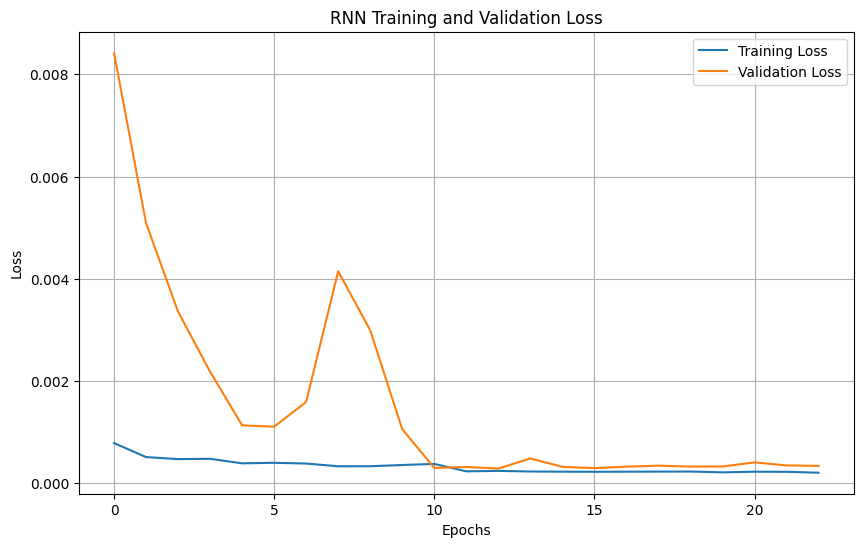

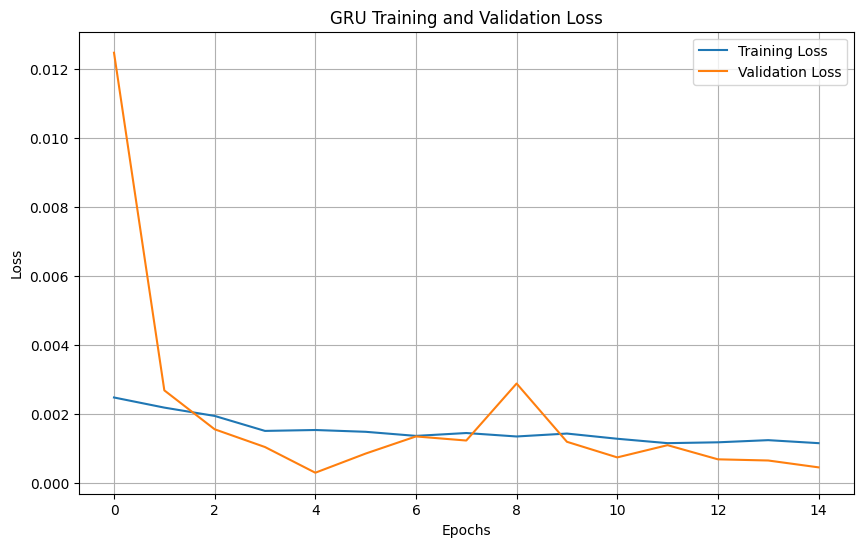

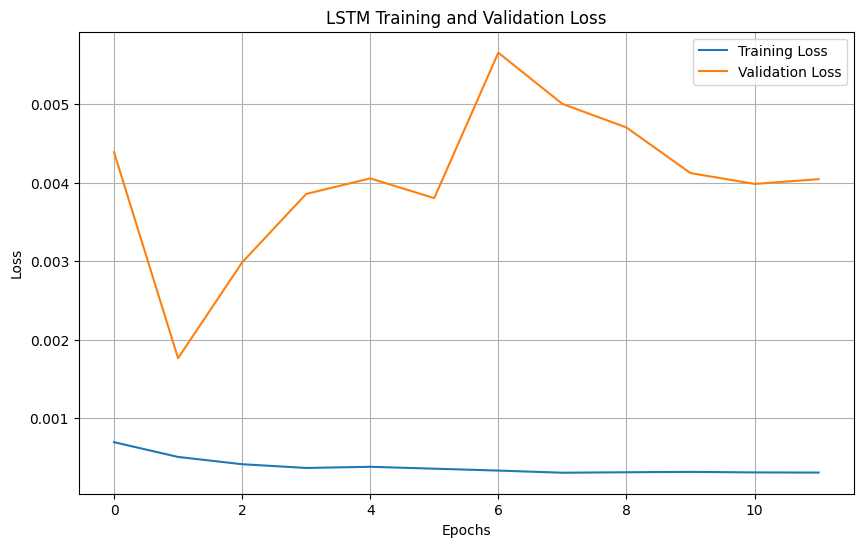

In [14]:
## Step 9: Plot Training Curves

def plot_training_curves(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot curves for best models
plot_training_curves(best_rnn_history, 'RNN')
plot_training_curves(best_gru_history, 'GRU')
plot_training_curves(best_lstm_history, 'LSTM')

## Evaluate Models on the Test Set

In [15]:
def mda(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  # Ensure y_true is float32
    y_pred = K.cast(y_pred, dtype='float32')  # Ensure y_pred is float32
    return K.mean(K.equal(K.sign(y_true[1:] - y_true[:-1]), K.sign(y_pred[1:] - y_pred[:-1])))

In [16]:
# Evaluate Models on the Test Set
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    test_mse = K.mean(K.square(y_test - predictions.flatten()))  # MSE calculation
    test_rmse = K.sqrt(test_mse)  # RMSE derived from MSE
    test_mae = K.mean(K.abs(y_test - predictions.flatten()))  # MAE
    test_mda = mda(y_test, predictions.flatten())  # MDA

    print(f"Evaluation Results for {model_name}:")
    print(f"Test MSE: {test_mse:.5f}, Test RMSE: {test_rmse:.5f}, Test MAE: {test_mae:.5f}, Test MDA: {test_mda:.5f}")
    return test_mse, test_rmse, test_mae, test_mda

# Evaluate each model and print its name
rnn_mse, rnn_rmse, rnn_mae, rnn_mda = evaluate_model(best_rnn_model, X_test, y_test, "RNN")
gru_mse, gru_rmse, gru_mae, gru_mda = evaluate_model(best_gru_model, X_test, y_test, "GRU")
lstm_mse, lstm_rmse, lstm_mae, lstm_mda = evaluate_model(best_lstm_model, X_test, y_test, "LSTM")

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Evaluation Results for RNN:
Test MSE: 0.00453, Test RMSE: 0.06730, Test MAE: 0.04516, Test MDA: 0.48150
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluation Results for GRU:
Test MSE: 0.00809, Test RMSE: 0.08993, Test MAE: 0.05742, Test MDA: 0.47238
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluation Results for LSTM:
Test MSE: 0.14050, Test RMSE: 0.37483, Test MAE: 0.29975, Test MDA: 0.48251


## Visualize Predictions

In [17]:
metrics_data = {
    'Model': ['RNN', 'GRU', 'LSTM'],
    'Test MSE': [float(rnn_mse.numpy()), float(gru_mse.numpy()), float(lstm_mse.numpy())],
    'Test RMSE': [float(rnn_rmse.numpy()), float(gru_rmse.numpy()), float(lstm_rmse.numpy())],
    'Test MAE': [float(rnn_mae.numpy()), float(gru_mae.numpy()), float(lstm_mae.numpy())],
    'Test MDA': [float(rnn_mda.numpy()), float(gru_mda.numpy()), float(lstm_mda.numpy())],
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)


  Model  Test MSE  Test RMSE  Test MAE  Test MDA
0   RNN  0.004530   0.067303  0.045164  0.481500
1   GRU  0.008087   0.089929  0.057425  0.472377
2  LSTM  0.140497   0.374829  0.299753  0.482514


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


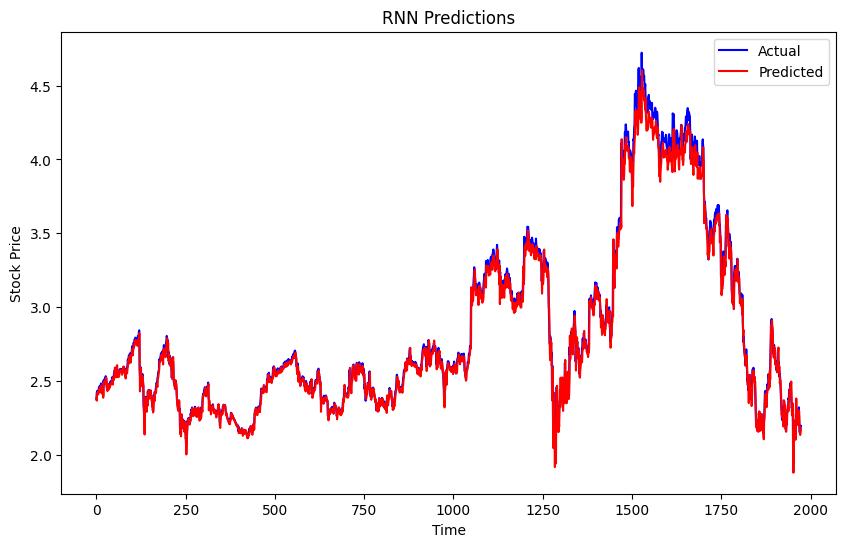

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


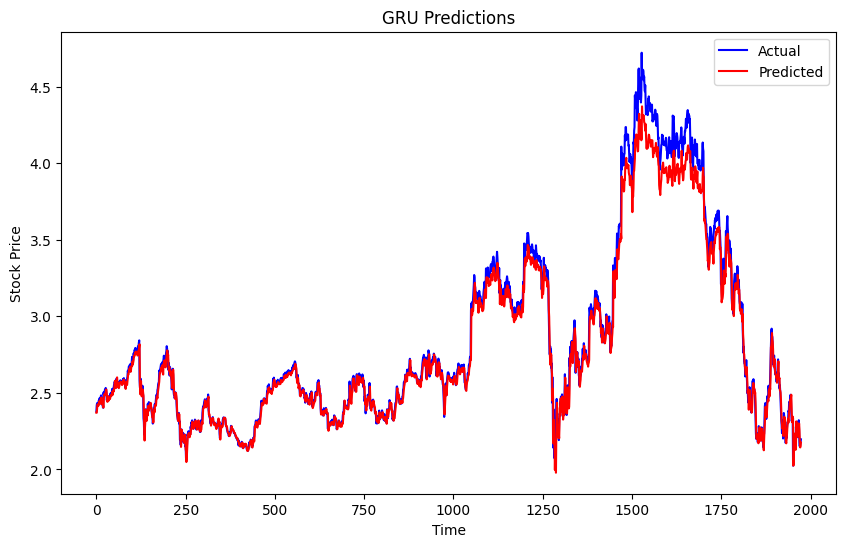

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


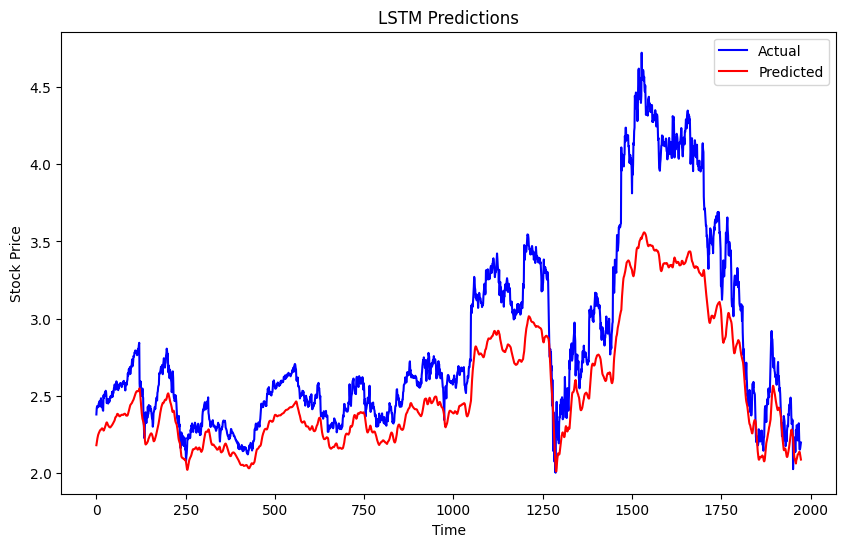

In [18]:
# Visualize Predictions
def plot_predictions(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(f'{model_name} Predictions')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

plot_predictions(best_rnn_model, X_test, y_test, "RNN")
plot_predictions(best_gru_model, X_test, y_test, "GRU")
plot_predictions(best_lstm_model, X_test, y_test, "LSTM")

## Combined Model Comparison

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


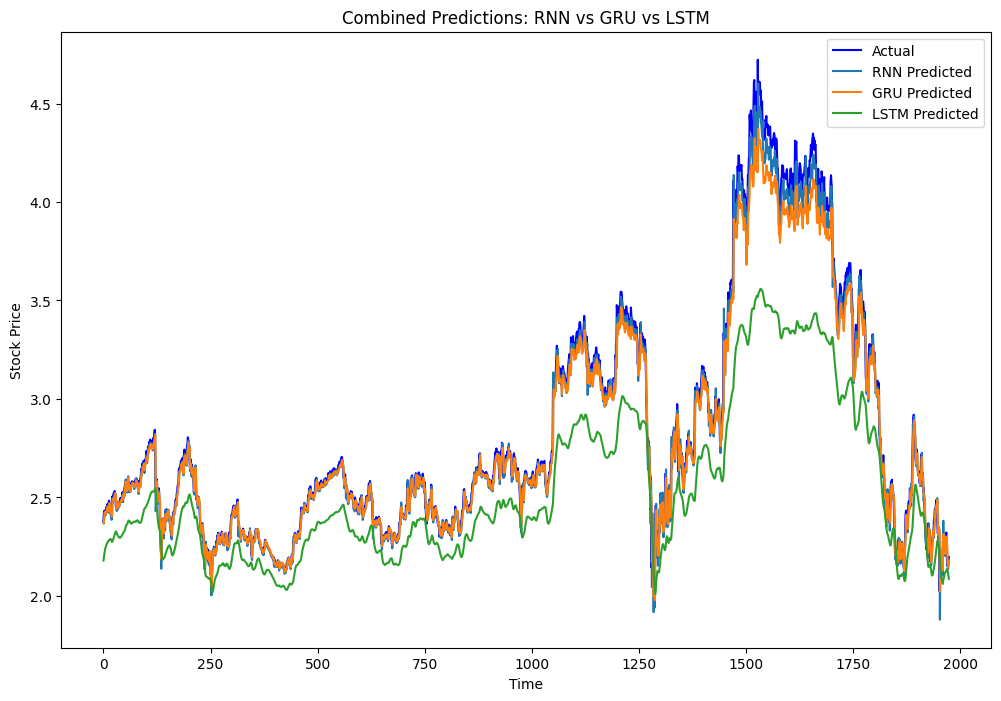

In [19]:
# Combined Prediction Plot
def plot_combined_predictions(models, model_names, X_test, y_test):
    plt.figure(figsize=(12, 8))
    plt.plot(y_test, label='Actual', color='blue')
    for model, name in zip(models, model_names):
        predictions = model.predict(X_test)
        plt.plot(predictions, label=f'{name} Predicted')
    plt.title('Combined Predictions: RNN vs GRU vs LSTM')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

models = [best_rnn_model, best_gru_model, best_lstm_model]
model_names = ["RNN", "GRU", "LSTM"]
plot_combined_predictions(models, model_names, X_test, y_test)

## Bar Chart for Evaluation Metrics

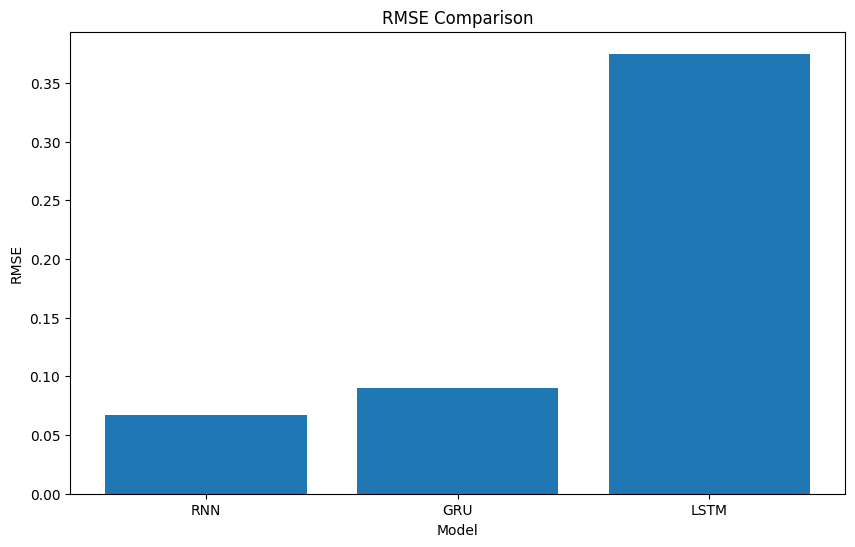

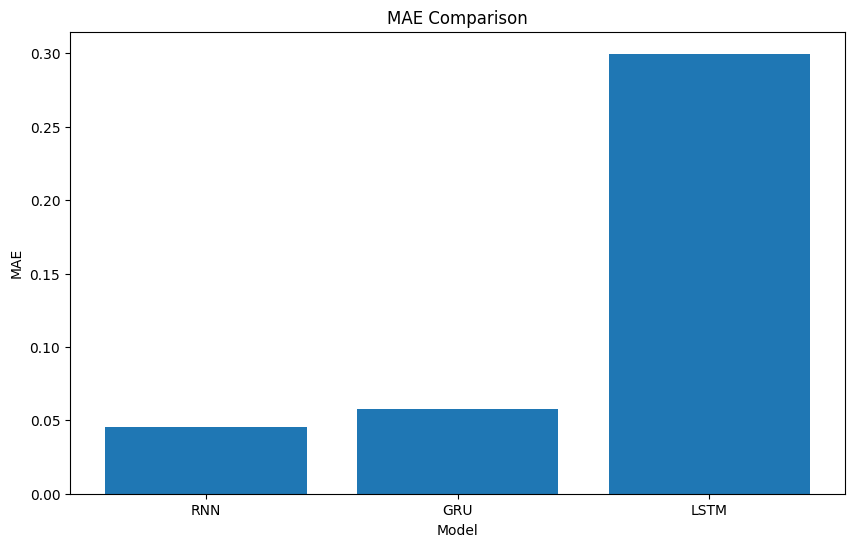

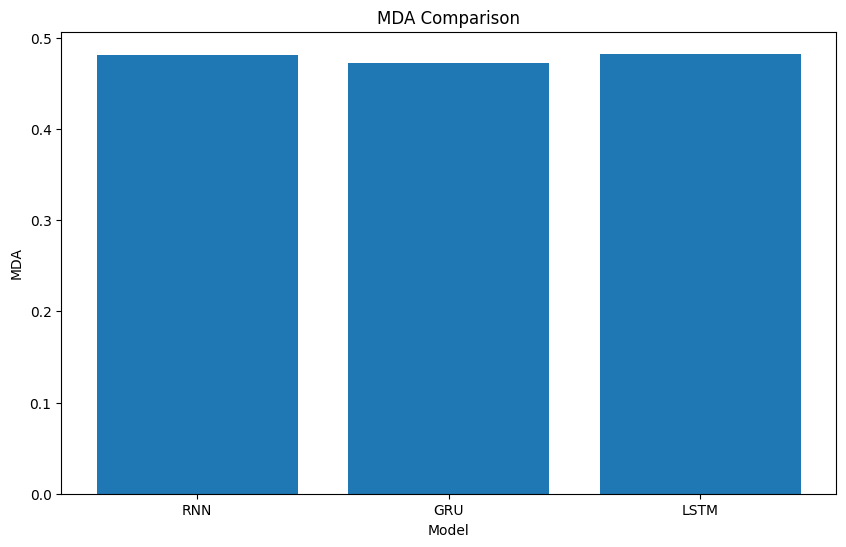

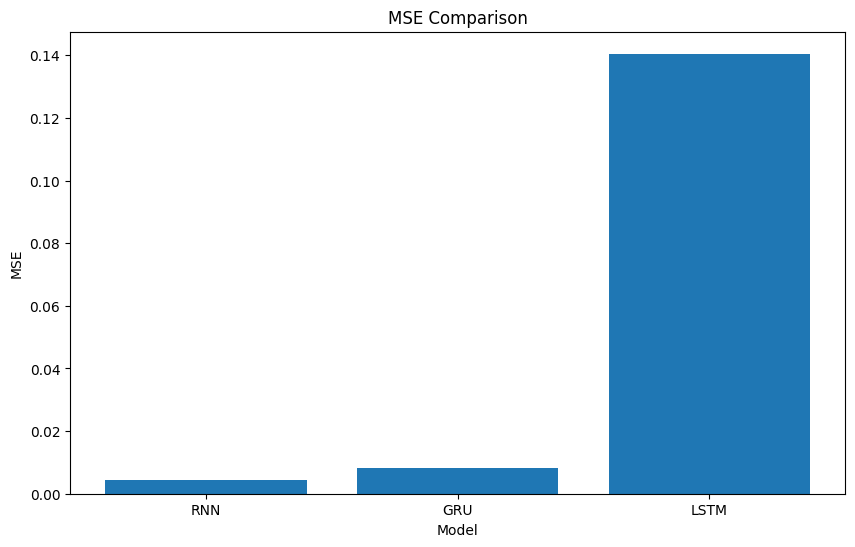

In [20]:
def plot_bar_chart(metrics, labels, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, metrics)
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel(ylabel)
    plt.show()

# Plot RMSE Bar Chart
plot_bar_chart([rnn_rmse, gru_rmse, lstm_rmse], ["RNN", "GRU", "LSTM"], "RMSE Comparison", "RMSE")

# Plot MAE Bar Chart
plot_bar_chart([rnn_mae, gru_mae, lstm_mae], ["RNN", "GRU", "LSTM"], "MAE Comparison", "MAE")

# Plot MDA Bar Chart
plot_bar_chart([rnn_mda, gru_mda, lstm_mda], ["RNN", "GRU", "LSTM"], "MDA Comparison", "MDA")

# Plot MSE Bar Chart
plot_bar_chart([rnn_mse, gru_mse, lstm_mse], ["RNN", "GRU", "LSTM"], "MSE Comparison", "MSE")